In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# to ignore the warning of pandas chained assignment
pd.options.mode.chained_assignment = None

# dataset from https://www.kaggle.com/robikscube/hourly-energy-consumption

# using pjm_hourly_est.csv file because it has the records of the whole PJM regions together
df = pd.read_csv('data/pjm_hourly_est.csv')

# sort by date
df.sort_values(by=['Datetime'], inplace=True)

# set Datetime as index
df.set_index('Datetime', inplace=True)

# convert index to datetime
df.index = pd.to_datetime(df.index)


df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0
1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0
1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0
1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0
1998-04-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20713.0


In [310]:
# describing the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [311]:
# check for duplicates
df.duplicated().sum()

16181

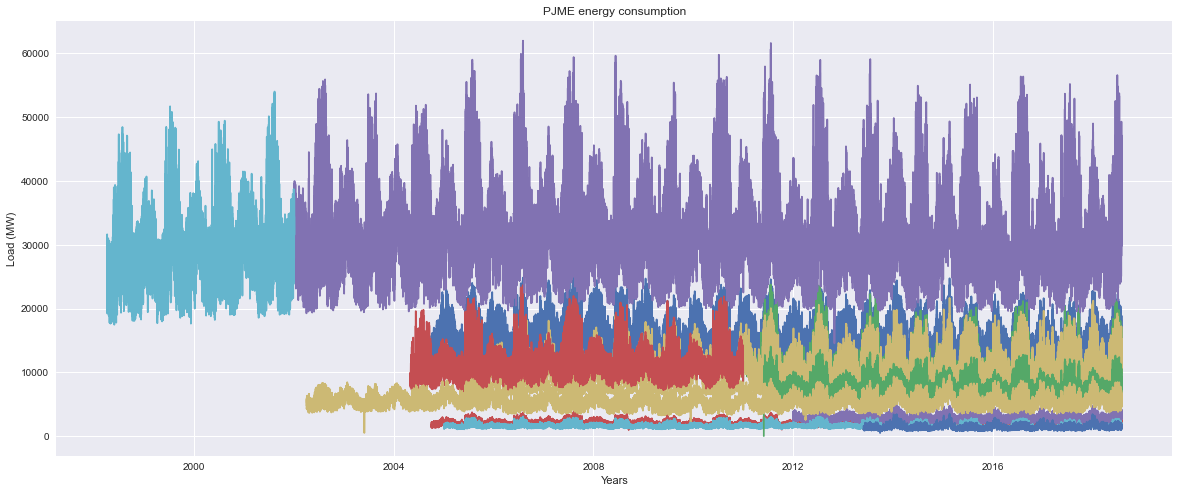

In [312]:

# Distribution of Load for all regions
plt.style.use('seaborn')
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

# we see that each region has a different energy consumption pattern
# so its better to make predictions for each region separately
# we choose the region with the most data "least missing values"

<AxesSubplot:>

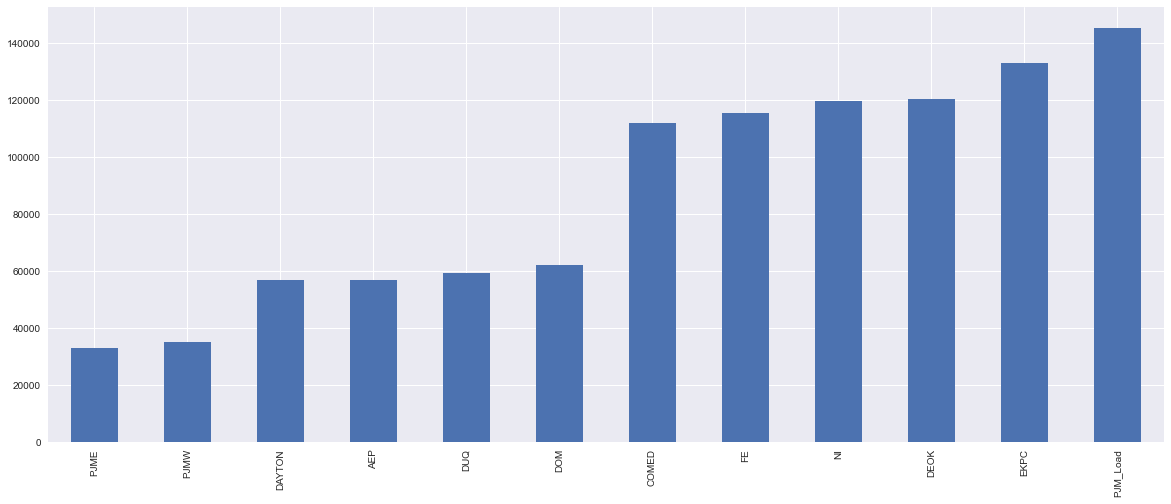

In [313]:
# check for missing values
missing_values_df = df.isnull().sum()

# plot the missing values
missing_values_df.sort_values(ascending=True).plot(kind='bar', figsize=(20, 8))

# the one with the least missing values is PJME

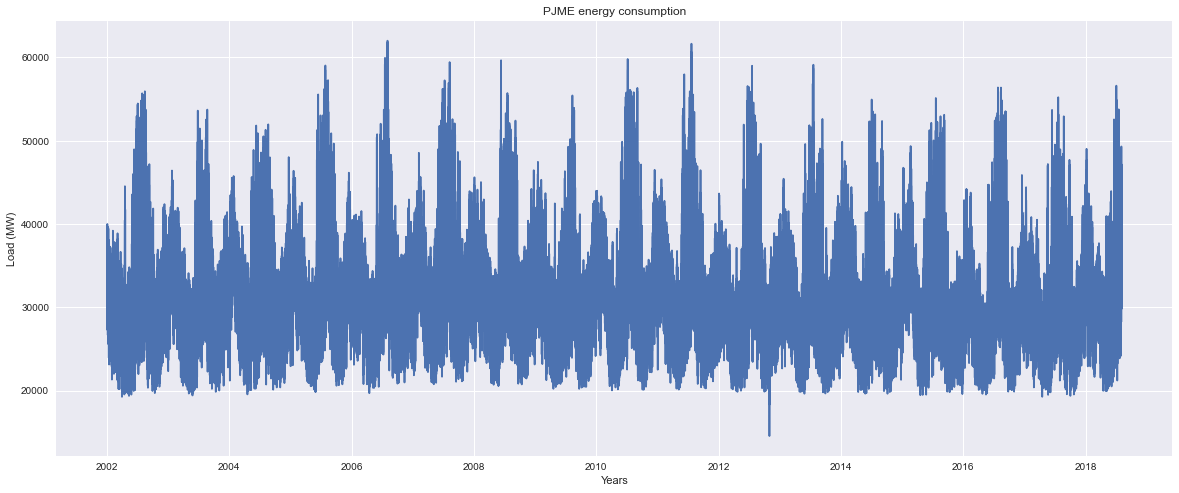

In [314]:
# removing all columns except PJME
df = df[['PJME']]

# removing the missing values
df.dropna(inplace=True)

# visualizing the data
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

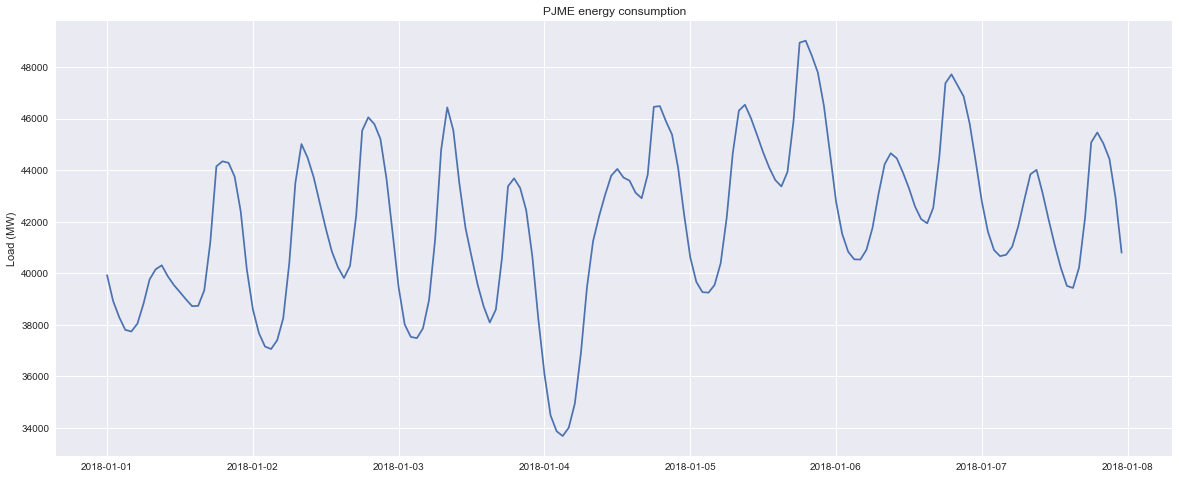

In [315]:
# visualizing a single week
plt.figure(figsize=(20, 8))
plt.plot(df['2018-01-01':'2018-01-07'])
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

In [316]:
# a function that will split the index to be used for hourly, daily, weekly, monthly, yearly and seasonal analysis

def split_df_features_for_plotting(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['day_of_week'] = df['day_of_week'].replace({0: 'monday', 1: 'tuesday', 2: 'wednesday', 3: 'thursday', 4: 'friday', 5: 'saturday', 6: 'sunday'})
    df['month'] = df.index.month
    df['month'] = df['month'].replace({1: 'january', 2: 'february', 3: 'march', 4: 'april', 5: 'may', 6: 'june', 7: 'july', 8: 'august', 9: 'september', 10: 'october', 11: 'november', 12: 'december'})
    df['year'] = df.index.year
    df['season'] = df.index.month % 12 // 3 + 1
    df['season'] = df['season'].replace({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
    return df

def split_df_features_for_modeling(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df.index.month % 12 // 3 + 1
    return df

df2 = df.copy()
df2 = split_df_features_for_plotting(df2)
df2.head()

,PJME,hour,day_of_week,month,year,season
Datetime,,,,,,
2002-01-01 01:00:00,30393.0,1,tuesday,january,2002,winter
2002-01-01 02:00:00,29265.0,2,tuesday,january,2002,winter
2002-01-01 03:00:00,28357.0,3,tuesday,january,2002,winter
2002-01-01 04:00:00,27899.0,4,tuesday,january,2002,winter
2002-01-01 05:00:00,28057.0,5,tuesday,january,2002,winter


Text(0.5, 1.0, 'PJME energy consumption by hour')

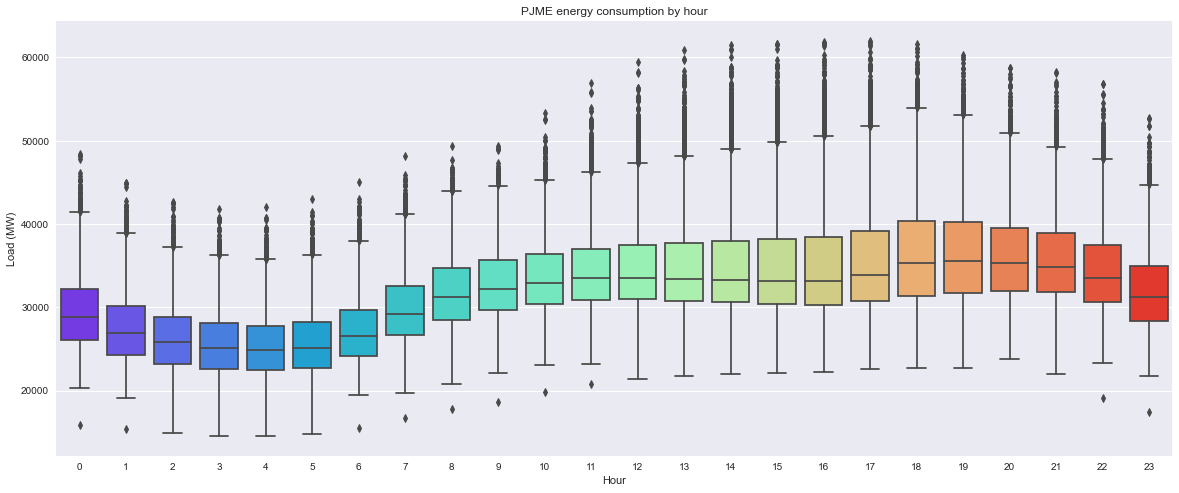

In [317]:
# we use seaborn to visualize the data
# plotting the hourly energy use

plt.figure(figsize=(20, 8))
sns.boxplot(x='hour', y='PJME', data=df2, palette='rainbow')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by hour')

Text(0.5, 1.0, 'PJME energy consumption by month')

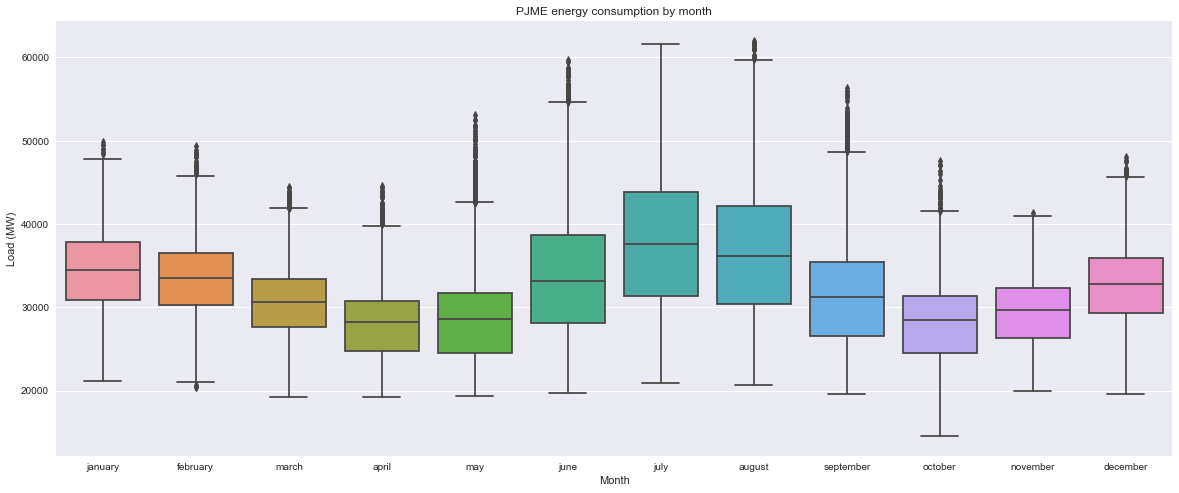

In [318]:
# plotting the monthly energy use

plt.figure(figsize=(20, 8))
sns.boxplot(x='month', y='PJME', data=df2)
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by month')


Text(0.5, 1.0, 'PJME energy consumption by day of week')

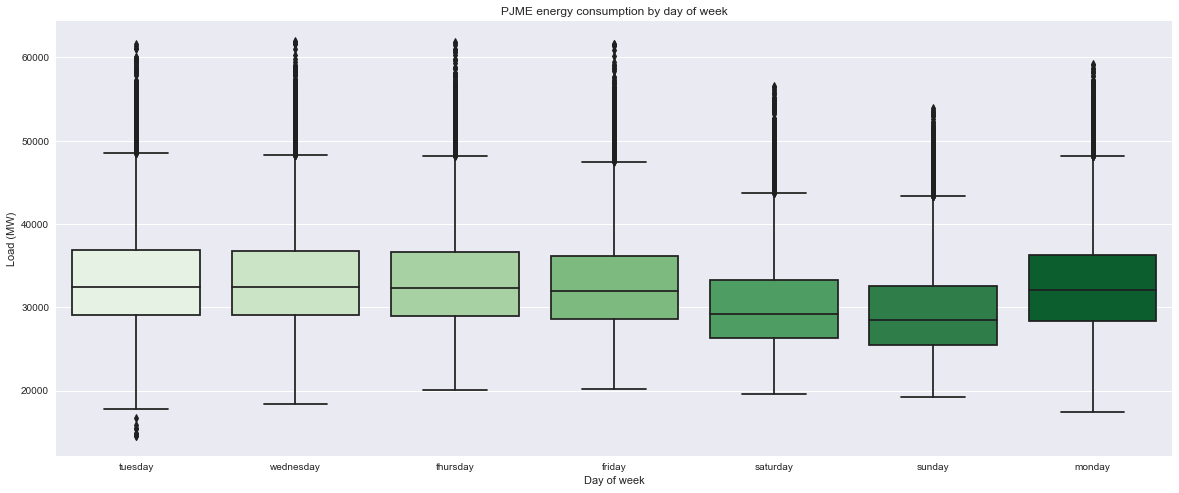

In [319]:
# plotting the daily energy use
plt.figure(figsize=(20, 8))
sns.boxplot(x='day_of_week', y='PJME', data=df2, palette='Greens')
plt.xlabel('Day of week')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by day of week')

Text(0.5, 1.0, 'PJME energy consumption by season')

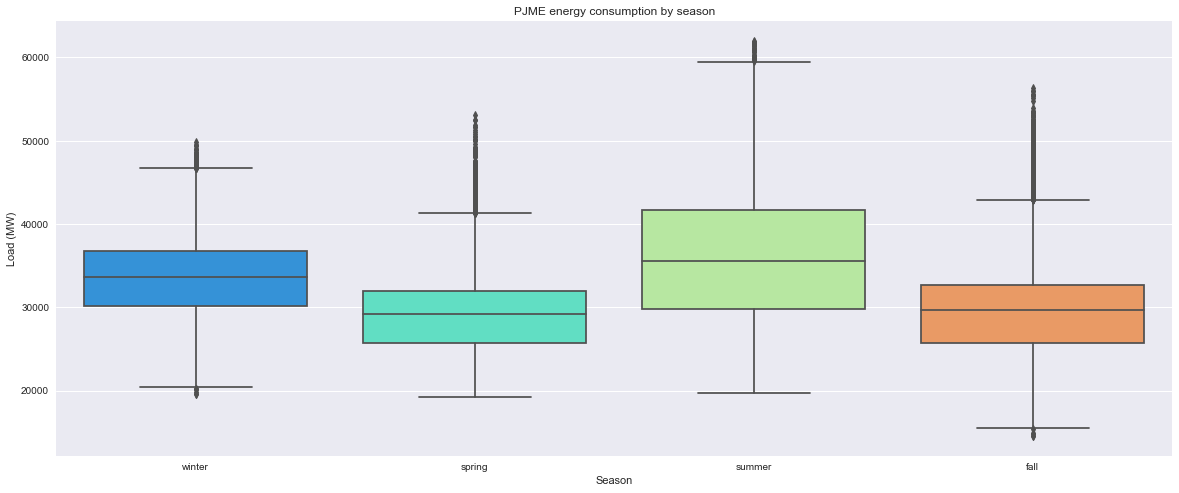

In [320]:
# plotting the seasonal energy use
plt.figure(figsize=(20, 8))
sns.boxplot(x='season', y='PJME', data=df2, palette='rainbow')
plt.xlabel('Season')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by season')


Text(0.5, 1.0, 'PJME energy consumption by day of week and hour')

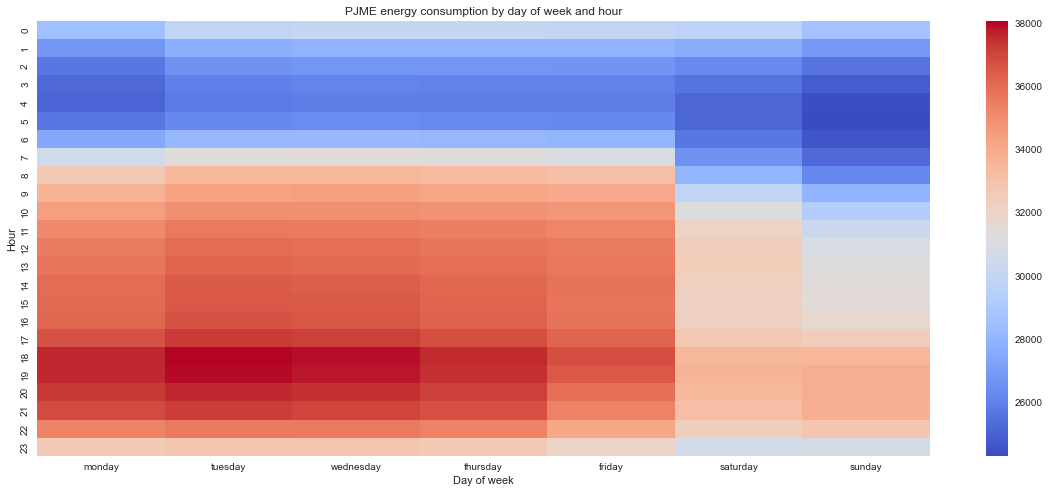

In [321]:
# heatmap of daily energy use
plt.figure(figsize=(20, 8))

# sorting the day of week before plotting
df2['day_of_week'] = pd.Categorical(df2['day_of_week'], categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], ordered=True)

sns.heatmap(df2.groupby(['hour', 'day_of_week'])['PJME'].mean().unstack(), cmap='coolwarm')
plt.xlabel('Day of week')
plt.ylabel('Hour')
plt.title('PJME energy consumption by day of week and hour')


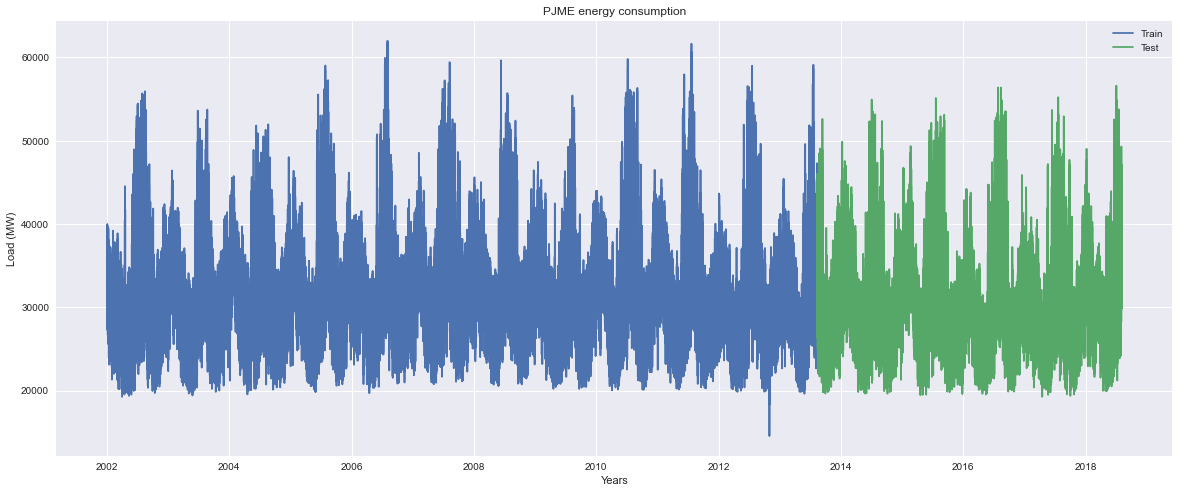

In [322]:
# creating the model section
# 1st split the data into train and test
# 2nd create an XGBRegressor model
# 3rd fit the model
# 4th predict the values
# 5th evaluate the model score on weekly, monthly, yearly and seasonal basis


# splitting the data into test 70% train and 30% test
test_size = int(len(df) * 0.3)
test_index = len(df) - test_size
train = df[:test_index]
test = df[test_index:]

# plotting the train and test data
plt.figure(figsize=(20, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

In [323]:
train = split_df_features_for_modeling(train)
test = split_df_features_for_modeling(test)

# assigning input and output variables
x_train = train.drop('PJME', axis=1)
y_train = train['PJME']

x_test = test.drop('PJME', axis=1)
y_test = test['PJME']


x_train.head()

,hour,day_of_week,month,year,season
Datetime,,,,,
2002-01-01 01:00:00,1,1,1,2002,1
2002-01-01 02:00:00,2,1,1,2002,1
2002-01-01 03:00:00,3,1,1,2002,1
2002-01-01 04:00:00,4,1,1,2002,1
2002-01-01 05:00:00,5,1,1,2002,1


In [327]:
import xgboost as xgb

# creating the model with hyperparameter

base_score = 0.5
booster = 'gbtree'
n_estimators = 1000
max_depth = 5
learning_rate = 0.01
objective = 'reg:linear'

model = xgb.XGBRegressor(base_score=base_score, booster=booster,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        early_stopping_rounds=50,
                        learning_rate=learning_rate,
                        objective=objective)

# fitting the model
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

[01:43:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32731.06980	validation_1-rmse:31609.54678
[100]	validation_0-rmse:12452.28699	validation_1-rmse:11484.96133
[200]	validation_0-rmse:5555.50336	validation_1-rmse:5076.69580
[300]	validation_0-rmse:3661.89179	validation_1-rmse:3830.05867
[400]	validation_0-rmse:3237.91669	validation_1-rmse:3720.71029
[451]	validation_0-rmse:3167.49794	validation_1-rmse:3737.22019


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

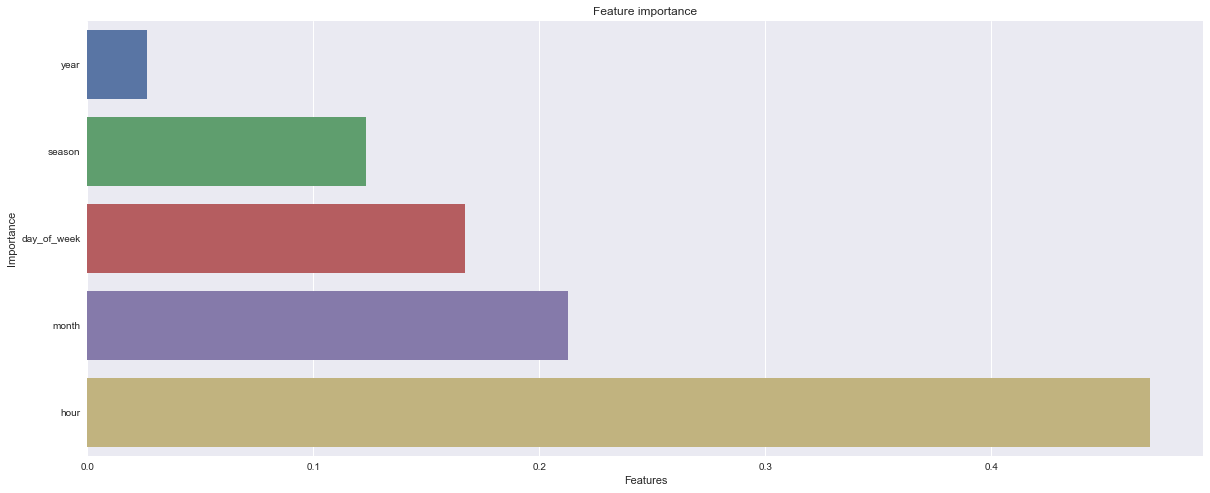

In [328]:
# plot the feature importance with good looking graph sns sorted by importance
plt.figure(figsize=(20, 8))
# soting the features by importance
sorted_idx = model.feature_importances_.argsort()
sns.barplot(x=model.feature_importances_[sorted_idx], y=x_train.columns[sorted_idx])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance')
plt.show()


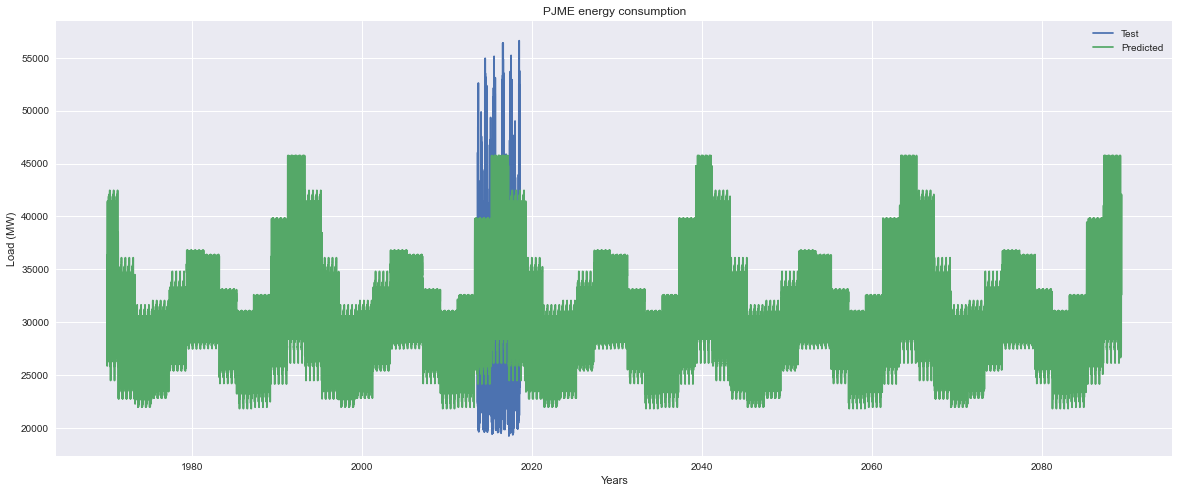

In [329]:
# predicting the values
y_pred = model.predict(x_test)

# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

In [330]:
# evaluating the model score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('Mean absolute error: ', mean_absolute_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))


Mean squared error:  13830318.200811196
Mean absolute error:  2803.7220959173424
R2 score:  0.6537124302420225


In [331]:
# predicting for the whole dataset
df = split_df_features_for_modeling(df)
df['PJME_pred'] = model.predict(df.drop('PJME', axis=1))

In [332]:
df

,PJME,hour,day_of_week,month,year,season,PJME_pred
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,26458.474609
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,25810.238281
2002-01-01 03:00:00,28357.0,3,1,1,2002,1,25654.138672
2002-01-01 04:00:00,27899.0,4,1,1,2002,1,25654.138672
2002-01-01 05:00:00,28057.0,5,1,1,2002,1,25713.929688
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,8,2018,3,40970.828125
2018-08-02 21:00:00,43256.0,21,3,8,2018,3,40908.140625
2018-08-02 22:00:00,41552.0,22,3,8,2018,3,39093.484375


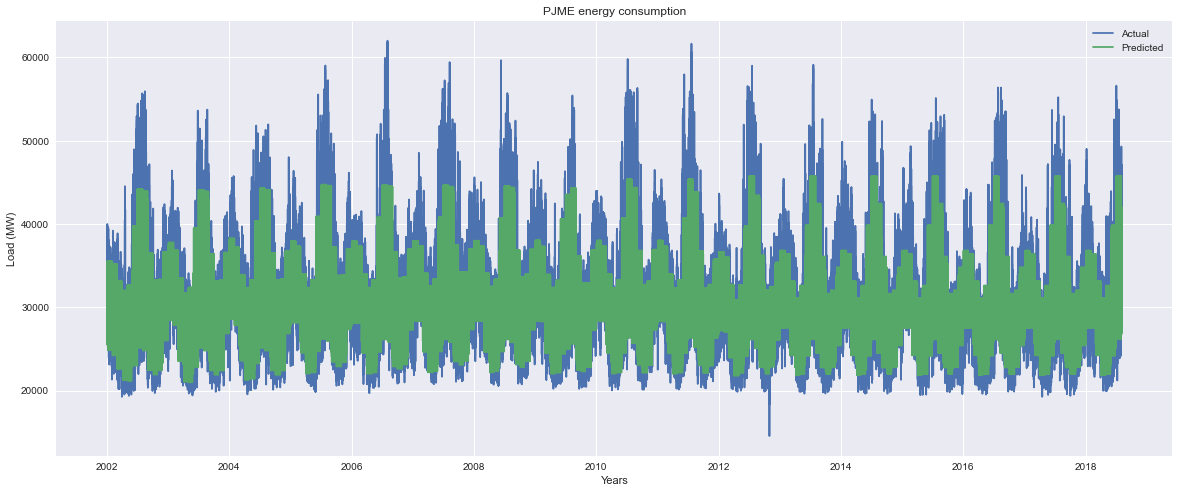

In [333]:
# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(df['PJME'], label='Actual')
plt.plot(df['PJME_pred'], label='Predicted')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()

In [335]:
print('Mean squared error: ', mean_squared_error(df['PJME'], df['PJME_pred']))
print('Mean absolute error: ', mean_absolute_error(df['PJME'], df['PJME_pred']))
print('R2 score: ', r2_score(df['PJME'], df['PJME_pred']))

Mean squared error:  11472132.231132401
Mean absolute error:  2463.1777770340254
R2 score:  0.7254365006242891


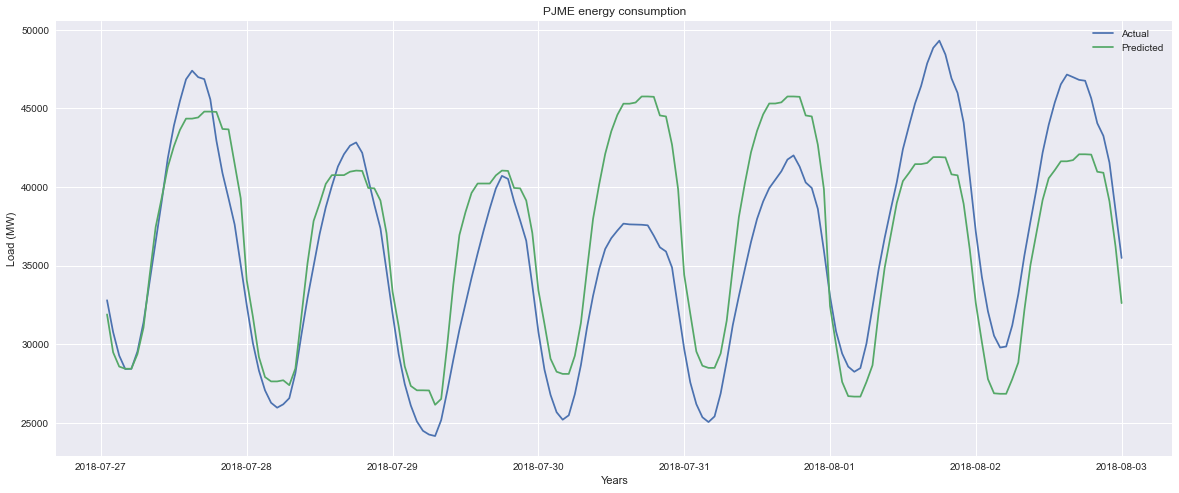

In [346]:
# predicting for a week
df_week = df[-7*24:]
df_week['PJME_pred'] = model.predict(df_week.drop(columns=['PJME', 'PJME_pred'], axis=1))

# plotting the predicted values
plt.figure(figsize=(20, 8))
plt.plot(df_week['PJME'], label='Actual')
plt.plot(df_week['PJME_pred'], label='Predicted')
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.legend()
plt.show()


In [343]:
# evaluating the model score
print('Mean squared error: ', mean_squared_error(df_week['PJME'], df_week['PJME_pred']))
print('Mean absolute error: ', mean_absolute_error(df_week['PJME'], df_week['PJME_pred']))
print('R2 score: ', r2_score(df_week['PJME'], df_week['PJME_pred']))


Mean squared error:  14853041.445991334
Mean absolute error:  3242.74462890625
R2 score:  0.6709254277364207
